In [4]:
# !pip install torchmetrics

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from typing import Dict, List, Tuple


In [6]:
torch.manual_seed(42)
np.random.seed(42)

In [7]:
# with open('/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
with open('SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
    instances = f.read()
    
instances = instances.split('\n')
instances[:5]

['0001_001_S6_00100_00060_3200_L',
 '0002_001_S6_00100_00020_3200_N',
 '0003_001_S6_00100_00060_3200_H',
 '0004_001_S6_00100_00060_4400_L',
 '0005_001_S6_00100_00060_4400_N']

In [8]:
# path = '/kaggle/input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/'
path = 'SIDD_Small_sRGB_Only/Data/'

noisy_images_path = []
gt_images_path = []

for f in instances:
    p = path + f + '/'
    for g in os.listdir(p):
        image_path = p + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)
            

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


In [9]:
from torch.utils.data import Dataset, DataLoader, Subset

class DenoisingDataset(Dataset):
    
    def __init__(
            self, 
            noisy_images, 
            gt_images, 
            augmentation=None, 
            crop_size=256
    ):
        self.noisy_images = noisy_images
        self.gt_images = gt_images
        self.augmentation = augmentation
        self.crop_size = crop_size

        self.noisy_patches = []
        self.gt_patches = []

        for img_idx in tqdm(range(len(self.noisy_images))):
            image = cv2.cvtColor(cv2.imread(self.noisy_images[img_idx]), cv2.COLOR_BGR2RGB)
            mask = cv2.cvtColor(cv2.imread(self.gt_images[img_idx]), cv2.COLOR_BGR2RGB)
            
            h, w, _ = image.shape
            mid_h, mid_w = h // 2, w // 2
            
            patches_coords = [
                (0, 0, mid_h, mid_w),
                (0, mid_w, mid_h, w),
                (mid_h, 0, h, mid_w),
                (mid_h, mid_w, h, w)
            ]
            
            for y1, x1, y2, x2 in patches_coords:
                noisy_patch = cv2.resize(image[y1:y2, x1:x2], (crop_size, crop_size))
                gt_patch = cv2.resize(mask[y1:y2, x1:x2], (crop_size, crop_size))
                self.noisy_patches.append(noisy_patch)
                self.gt_patches.append(gt_patch)

    def __getitem__(self, idx):
        noisy_image = self.noisy_patches[idx]
        gt_image = self.gt_patches[idx]

        # Convert from HWC to CHW format
        noisy_image = torch.from_numpy(noisy_image).permute(2, 0, 1).float() / 255.0
        gt_image = torch.from_numpy(gt_image).permute(2, 0, 1).float() / 255.0
        
        return noisy_image, gt_image

    def __len__(self):
        return len(self.noisy_patches)

def get_augmentation():
    train_transform = [    
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
            ],
            p=0.6667
        ),
    ]
    
    return A.Compose(train_transform)

class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentation, augmentations_per_image):
        self.base_dataset = base_dataset
        self.augmentation = augmentation
        self.augmentations_per_image = augmentations_per_image

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_image

    def __getitem__(self, idx):
        base_idx = idx // self.augmentations_per_image
        augment_idx = idx % self.augmentations_per_image
        
        noisy_image, gt_image = self.base_dataset[base_idx]
        
        if augment_idx > 0:  # Apply augmentation only on additional copies
            sample = self.augmentation(image=noisy_image.permute(1, 2, 0).numpy(), mask=gt_image.permute(1, 2, 0).numpy())
            noisy_image = torch.from_numpy(sample['image']).permute(2, 0, 1).float()
            gt_image = torch.from_numpy(sample['mask']).permute(2, 0, 1).float()
        
        return noisy_image, gt_image

# Definisikan augmentasi menggunakan fungsi
train_augmentation = get_augmentation()

denoising_dataset = DenoisingDataset(
    noisy_images=noisy_images_path,
    gt_images=gt_images_path,
    crop_size=256
)

# Tentukan ukuran training, validation, dan test set
train_size = int(0.8 * len(denoising_dataset))
valid_size = int(0.1 * len(denoising_dataset))
test_size = len(denoising_dataset) - train_size - valid_size

# Membagi dataset menjadi training, validation, dan test set
train_indices, valid_indices, test_indices = random_split(range(len(denoising_dataset)), [train_size, valid_size, test_size])

# Buat subset dengan augmentasi hanya untuk dataset training
train_dataset = AugmentedDataset(Subset(denoising_dataset, train_indices), train_augmentation, augmentations_per_image=3)
valid_dataset = Subset(denoising_dataset, valid_indices)
test_dataset = Subset(denoising_dataset, test_indices)

# Membuat DataLoader untuk train, validasi, dan test dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

100%|██████████| 160/160 [03:50<00:00,  1.44s/it]


In [10]:
print(f"Size of training set: {len(train_dataset)}")
print(f"Size of validation set: {len(valid_dataset)}")
print(f"Size of test set: {len(test_dataset)}")

Size of training set: 1536
Size of validation set: 64
Size of test set: 64


In [11]:
FILTER = 32

In [12]:
class LayerNormFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)
def replace_layers(model, base_size, train_size, fast_imp, **kwargs):
    for n, m in model.named_children():
        if len(list(m.children())) > 0:
            ## compound module, go inside it
            replace_layers(m, base_size, train_size, fast_imp, **kwargs)

        if isinstance(m, nn.AdaptiveAvgPool2d):
            pool = AvgPool2d(base_size=base_size, fast_imp=fast_imp, train_size=train_size)
            assert m.output_size == 1
            setattr(model, n, pool)

class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

class HalfUNet(nn.Module):
    def __init__(self, input_channels=3):
        super(HalfUNet, self).__init__()
        self.initial = nn.Conv2d(3, FILTER, 1, 1)
        self.conv1 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Sequential(
            NAFBlock(FILTER),
            NAFBlock(FILTER)
        )

        self.conv_up3 = nn.Conv2d(FILTER, FILTER * 16, 1, bias=False)
        self.up3 = nn.PixelShuffle(4)
        self.conv_up2 = nn.Conv2d(FILTER, FILTER * 4, 1, bias=False)
        self.up2 = nn.PixelShuffle(2)
        self.final_conv = nn.Conv2d(FILTER, 3, kernel_size=1)
        # If you want to perform multi-class segmentation, change the output channels to the desired number

    def forward(self, x):
        x = self.initial(x)
        x1 = self.conv1(x)
        pool1 = self.pool1(x1)
        x2 = self.conv2(pool1)
        pool2 = self.pool2(x2)
        x3 = self.conv3(pool2)

        up3 = self.conv_up3(x3)
        up3 = self.up3(up3)

        up2 = self.conv_up2(x2)
        up2 = self.up2(up2)
        up_scaled = x1 + up2 + up3
        output = self.final_conv(up_scaled)
        return output

# Example usage:
input_tensor = torch.randn(1, 3, 256, 256)  # Example input tensor
model = HalfUNet()
output_tensor = model(input_tensor)
print(output_tensor.shape)  # Print the shape of the output tensor

torch.Size([1, 3, 256, 256])


In [13]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def psnr(img1, img2, data_range=1.0):
    mse = F.mse_loss(img1, img2)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val

def loss_func(x, y):
    return 100 - psnr(x, y)

In [14]:
def evaluate_model(model, dataloader, device=device):
    model.to(device)
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss_val = loss_func(outputs, targets)
            psnr_val = psnr(outputs, targets)
            ssim_val = ssim(outputs, targets)

            total_loss += loss_val.item()
            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()

    avg_loss = total_loss / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)
    avg_ssim = total_ssim / len(dataloader)

    return avg_loss, avg_psnr, avg_ssim

In [15]:
# train_loss = []
# train_psnr = []
# train_ssim = []
# val_loss = []
# val_psnr = []
# val_ssim = []

In [16]:
def train_model(model, num_epochs=10):
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
    
        total_loss = 0.0
        total_psnr = 0.0
        total_ssim = 0.0
    
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
    
            outputs = model(inputs)
    
            loss = loss_func(outputs, targets)
            psnr_val = psnr(outputs, targets)
            ssim_val = ssim(outputs, targets)
    
            total_loss += loss.item()
            total_psnr += psnr_val.item()
            total_ssim += ssim_val.item()
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            loop.set_description(f'Step [{batch_idx+1}/{len(train_loader)}]')
            loop.set_postfix(loss=loss.item(), psnr=psnr_val.item(), ssim=ssim_val.item())
    
        avg_loss = total_loss / len(train_loader)
        avg_psnr = total_psnr / len(train_loader)
        avg_ssim = total_ssim / len(train_loader)
    
        print(f"\nAvg Loss: {avg_loss:.4f}, Avg PSNR: {avg_psnr:.4f}, Avg SSIM: {avg_ssim:.4f}")
    
        avg_loss_val, avg_psnr_val, avg_ssim_val = evaluate_model(model, valid_loader, device)
        print(f"Val Loss: {avg_loss_val}, Val PSNR: {avg_psnr_val:.4f}, Val SSIM: {avg_ssim_val:.4f}")
    
        # train_loss.append(avg_loss)
        # train_psnr.append(avg_psnr)
        # train_ssim.append(avg_ssim)
        # val_loss.append(avg_loss_val)
        # val_psnr.append(avg_psnr_val)
        # val_ssim.append(avg_ssim_val)
    
        torch.save(model.state_dict(), 'naf_128_double.pth')

    return model

In [17]:
# model = train_model(model, num_epochs=10)

In [18]:
# epochs = range(1, len(train_loss) + 1)

# # Plotting train loss
# plt.figure(figsize=(5, 5))
# plt.plot(epochs, train_loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Val Loss')
# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plotting train PSNR
# plt.figure(figsize=(5, 5))
# plt.plot(epochs, train_psnr, 'r', label='Training PSNR')
# plt.plot(epochs, val_psnr, 'b', label='Val PSNR')
# plt.title('PSNR')
# plt.xlabel('Epochs')
# plt.ylabel('PSNR')
# plt.legend()
# plt.show()

# # Plotting train SSIM
# plt.figure(figsize=(5, 5))
# plt.plot(epochs, train_ssim, 'r', label='Training SSIM')
# plt.plot(epochs, val_ssim, 'b', label='Val SSIM')
# plt.title('SSIM')
# plt.xlabel('Epochs')
# plt.ylabel('SSIM')
# plt.legend()
# plt.show()

In [19]:
# Build model and load state_dict checkpoint
model = HalfUNet()
state = torch.load('naf_32_double.pth', map_location='cpu')
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
elif isinstance(state, dict) and 'model_state_dict' in state:
    state = state['model_state_dict']
# strip DataParallel prefix
state = { (k[7:] if isinstance(k, str) and k.startswith('module.') else k): v for k, v in state.items() }
model.load_state_dict(state, strict=False)
model = model.to('cpu').eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.025767118..0.9733024].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12263104..1.0404415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.100494616..1.0054293].


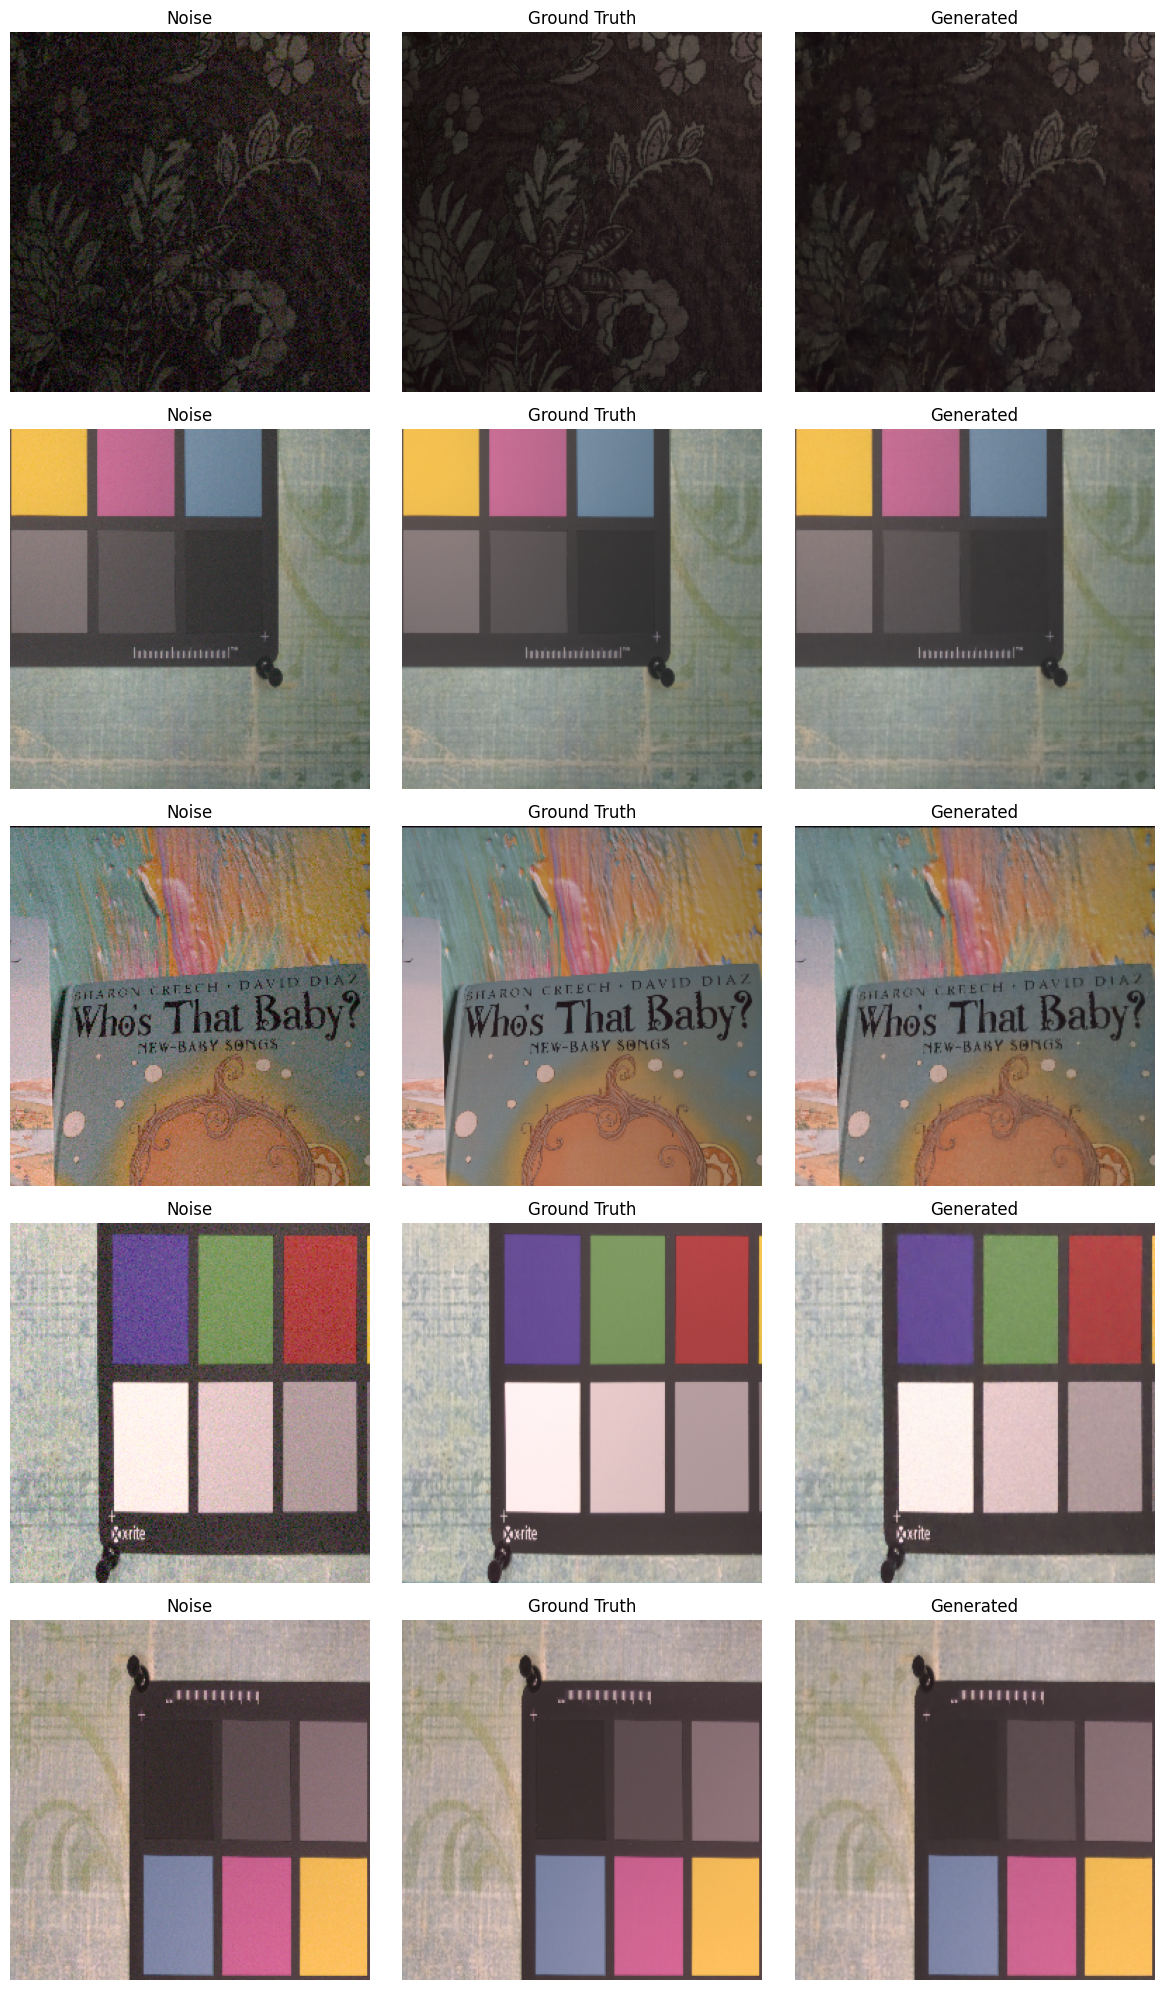

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0005441045..0.7971456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09030397..1.0212553].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010335636..0.6640915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.005338937..1.0384648].


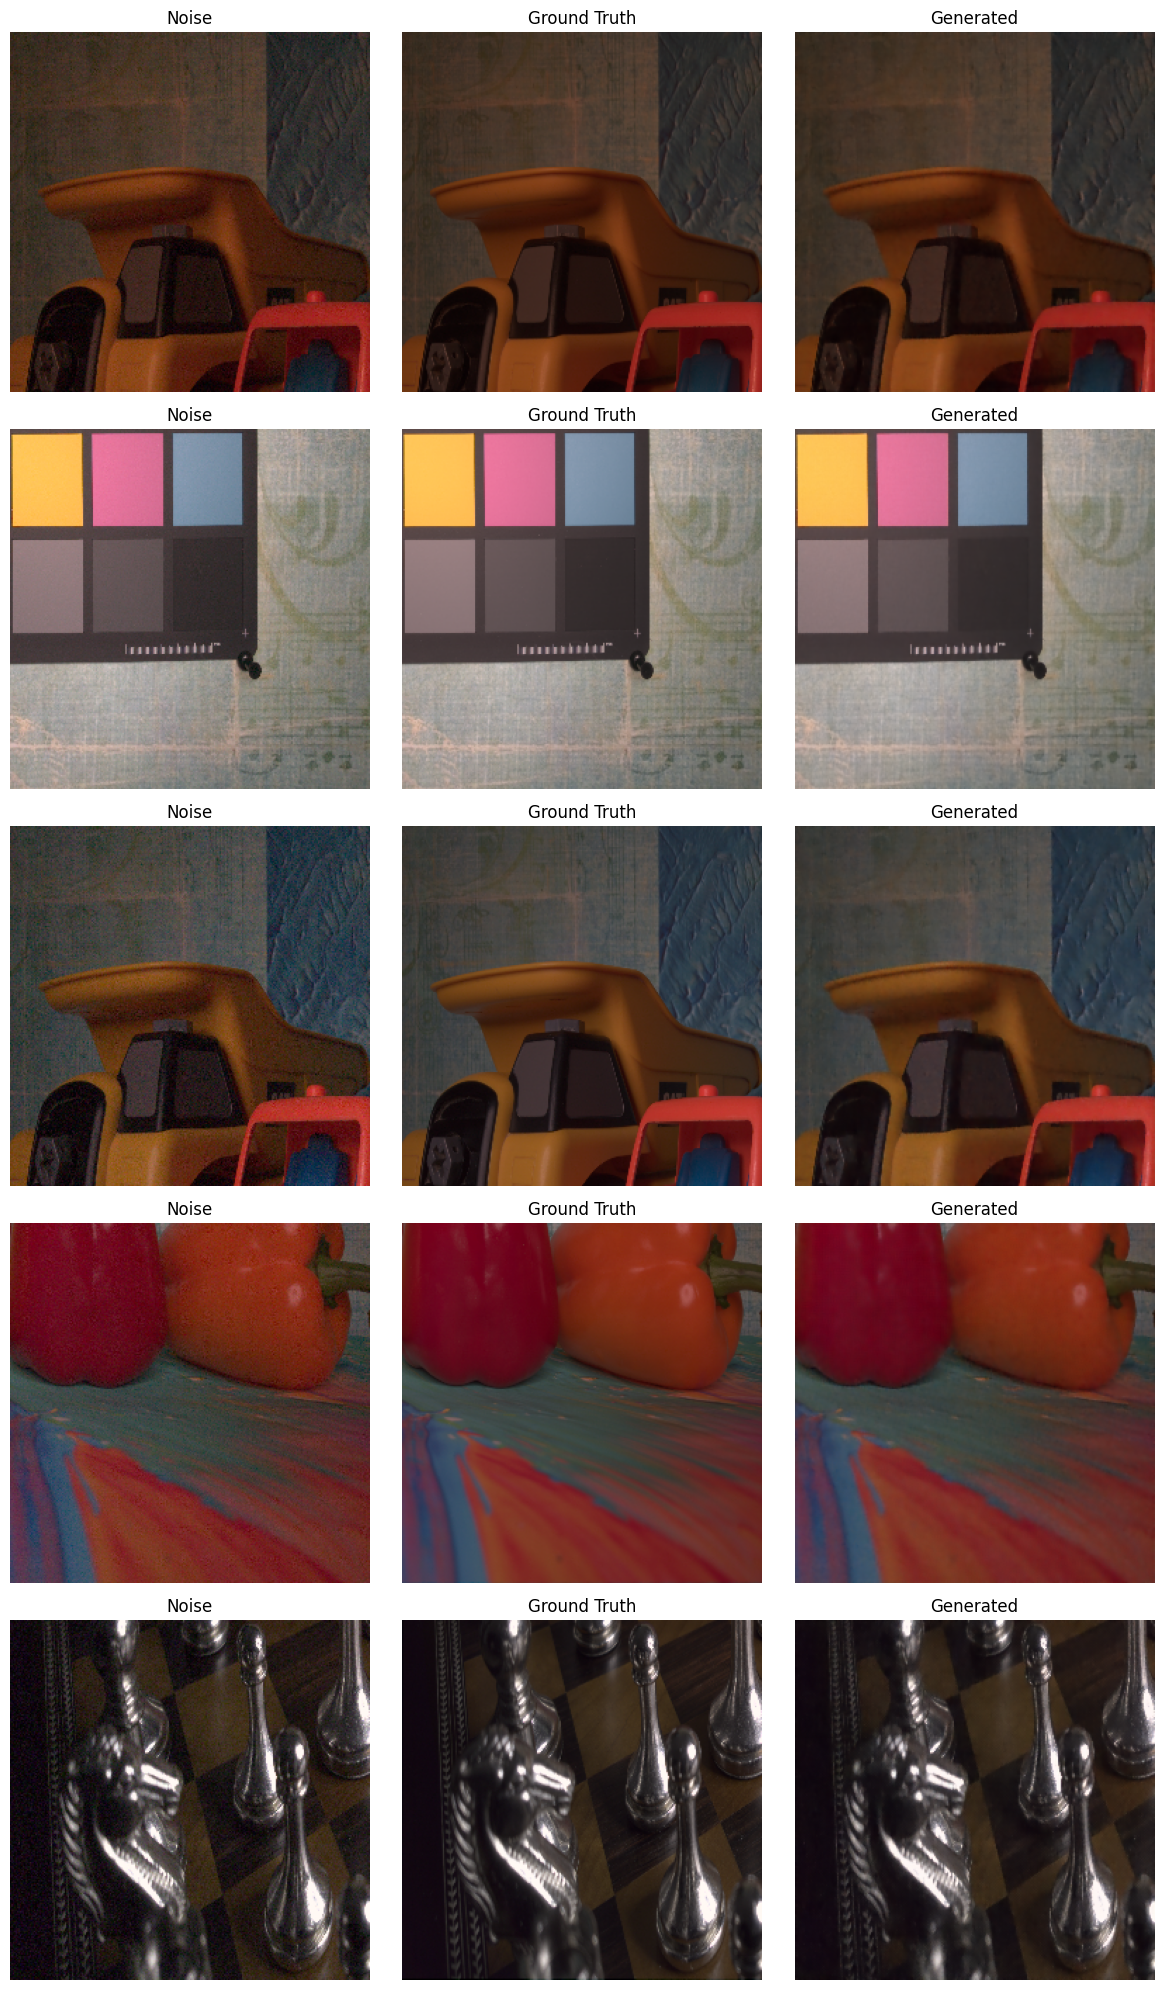

In [20]:
model = model.to('cpu')

# Ensure the model is not wrapped in DataParallel
if isinstance(model, torch.nn.DataParallel):
    model = model.module

model.eval()

# Iterate over a few batches from the test dataset
for batch_idx, (lr, hr) in enumerate(test_loader):
    # Move inputs to CPU
    imgs_lr = lr.cpu()
    imgs_hr = hr.cpu()

    # Forward pass: Generate high-resolution images
    with torch.no_grad():
        gen_hr = model(imgs_lr)

    # Visualize a few sample images
    num_samples = min(5, len(imgs_lr))  # Reduced number of samples for visualization

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    for i in range(num_samples):
        # Original LR image
        axes[i, 0].imshow(imgs_lr[i].permute(1, 2, 0).numpy())
        axes[i, 0].set_title("Noise")
        axes[i, 0].axis("off")

        # Ground truth HR image
        axes[i, 1].imshow(imgs_hr[i].permute(1, 2, 0).numpy())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Generated HR image
        axes[i, 2].imshow(gen_hr[i].permute(1, 2, 0).numpy())
        axes[i, 2].set_title("Generated")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Explicitly delete variables to free memory
    del imgs_lr, imgs_hr, gen_hr

    # Only visualize a few batches
    if batch_idx == 1:
        break

In [21]:
original_loss, original_psnr, original_ssim = evaluate_model(model, test_loader, device)
print(f"Original Model - Loss: {original_loss:.4f}, PSNR: {original_psnr:.4f}, SSIM: {original_ssim:.4f}")


Original Model - Loss: 62.7387, PSNR: 37.2613, SSIM: 0.9316


In [22]:
import torch.nn as nn

# Count total number of binary variables p[n,k]
_device = next(model.parameters()).device
conv_layers = [(i, name, m) for i, (name, m) in enumerate(model.named_modules()) if isinstance(m, nn.Conv2d)]
p = {i: torch.ones(m.out_channels, device=_device, dtype=m.weight.dtype) for i, name, m in conv_layers}

layer_counts = {name: int(p[i].numel()) for i, name, _ in conv_layers}
_total_p = sum(layer_counts.values())
print('Total p variables:', _total_p)


Total p variables: 2403


In [23]:
# Redefine with contiguous indices 0..N-1 so layer_idx is stable

def compute_A_matrices(
    model: nn.Module,
    store_on_cpu: bool = True,
) -> Tuple[List[Tuple[int, str, nn.Conv2d]], Dict[int, torch.Tensor], Dict[str, torch.Tensor]]:
    """Compute A_{n,i,j} for every Conv2d layer with contiguous indices.

    Returns:
      conv_layers: list of (layer_idx, layer_name, conv_module) where layer_idx = 0..N-1
      A_by_idx: dict layer_idx -> tensor [C_out, C_out]
      A_by_name: dict layer_name -> tensor [C_out, C_out]
    """
    convs: List[Tuple[str, nn.Conv2d]] = [
        (name, m) for name, m in model.named_modules() if isinstance(m, nn.Conv2d)
    ]
    conv_layers: List[Tuple[int, str, nn.Conv2d]] = [
        (i, name, m) for i, (name, m) in enumerate(convs)
    ]

    A_by_idx: Dict[int, torch.Tensor] = {}
    A_by_name: Dict[str, torch.Tensor] = {}

    for i, name, m in conv_layers:
        w = m.weight.detach()
        out_c = w.shape[0]
        w_flat = w.view(out_c, -1)
        l1_per_filter = w_flat.abs().sum(dim=1)
        N = w_flat.size(1)
        a = l1_per_filter / N
        if store_on_cpu:
            a = a.to('cpu')
        A = torch.outer(a, a)
        A_by_idx[i] = A
        A_by_name[name] = A

    return conv_layers, A_by_idx, A_by_name


def get_A_value_by_idx(A_by_idx: Dict[int, torch.Tensor], n: int, i: int, j: int) -> float:
    return float(A_by_idx[n][i, j])


# def get_A_value_by_name(A_by_name: Dict[str, torch.Tensor], layer_name: str, i: int, j: int) -> float:
#     return float(A_by_name[layer_name][i, j])

# Example usage (leave commented):
# conv_layers, A_by_idx, A_by_name = compute_A_matrices(model)
# val = get_A_value_by_idx(A_by_idx, layer_idx=0, i=3, j=7)
# val2 = get_A_value_by_name(A_by_name, 'conv1.0.conv1', 5, 5)
# Lp = compute_Lp_from_A(p, A_by_idx)


In [24]:
conv_layers, A_by_idx, A_by_name = compute_A_matrices(model)
val = get_A_value_by_idx(A_by_idx, n=0, i=3, j=7)
val

0.04827908053994179

In [25]:
param_dtypes = sorted({p.dtype for p in model.parameters()})
buffer_dtypes = sorted({b.dtype for b in model.buffers()})
print('param dtypes:', param_dtypes)
print('buffer dtypes:', buffer_dtypes)

param dtypes: [torch.float32]
buffer dtypes: []


In [26]:
def get_model_size(model: nn.Module) -> float:
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_bits = (param_size + buffer_size)
    return size_all_bits

S = get_model_size(model) * 8

print(f'model size: {S} bits')


model size: 2241632 bits


In [27]:
def compute_D_vectors(
    S_bits: int,
    model: nn.Module,
    b_max: int = 32,
) -> Tuple[List[Tuple[int, str, nn.Conv2d]], Dict[int, torch.Tensor], Dict[str, torch.Tensor], int]:
    """Compute D_{n,i} for every Conv2d layer.

    D_{n,i} = N_{n,i} * b_max / S, where
      - N_{n,i} is number of weights in filter i at layer n
        For Conv2d, N_{n,i} = (in_channels / groups) * kH * kW, identical for all i in layer n.
      - b_max is the bit-width of weights (default 32 for fp32)
      - S is the total model size in bits. If None, computed as (total_params * b_max).

    Returns:
      conv_layers: list of (layer_idx, layer_name, conv_module) with contiguous indices 0..N-1
      D_by_idx: dict layer_idx -> 1D tensor [out_channels] (each entry equals N*b_max/S)
      D_by_name: dict layer_name -> 1D tensor [out_channels]
      S_bits: the S actually used (in bits)
    """
    # Build contiguous conv list
    convs: List[Tuple[str, nn.Conv2d]] = [
        (name, m) for name, m in model.named_modules() if isinstance(m, nn.Conv2d)
    ]
    conv_layers: List[Tuple[int, str, nn.Conv2d]] = [
        (i, name, m) for i, (name, m) in enumerate(convs)
    ]

    D_by_idx: Dict[int, torch.Tensor] = {}
    D_by_name: Dict[str, torch.Tensor] = {}

    for i, name, m in conv_layers:
        w = m.weight
        out_c = w.shape[0]
        w_flat = w.view(out_c, -1)
        N = w_flat.size(1)
        D_val = (N * b_max) / S_bits
        D_vec = torch.full((out_c,), float(D_val))  # on CPU
        D_by_idx[i] = D_vec
        D_by_name[name] = D_vec

    return conv_layers, D_by_idx, D_by_name


def get_D_value_by_idx(D_by_idx: Dict[int, torch.Tensor], n: int, i: int) -> float:
    """Return D_{layer_idx,i} as float (identical for all i within the same layer)."""
    return float(D_by_idx[n][i])


# def get_D_value_by_name(D_by_name: Dict[str, torch.Tensor], layer_name: str, i: int) -> float:
#     """Return D for a layer by name."""
#     return float(D_by_name[layer_name][i])

# Example usage (leave commented):
# conv_layers, D_by_idx, D_by_name, S_bits = compute_D_vectors(model, b_max=32)
# dval = get_D_value_by_idx(D_by_idx, layer_idx=0, i=0)
# dval2 = get_D_value_by_name(D_by_name, 'conv1.0.conv1', 5)  


In [28]:
conv_layers, D_by_idx, D_by_name = compute_D_vectors(S, model, b_max=32)
val = get_D_value_by_idx(D_by_idx, n=0, i=0)
val

4.282594090909697e-05

In [29]:
var_labels = [f"p_{n}_{i}" for n in sorted(A_by_idx.keys()) for i in range(A_by_idx[n].shape[0])]
num_variables = len(var_labels)
print(f"The QUBO matrix Q has dimensions {num_variables}x{num_variables}")

The QUBO matrix Q has dimensions 2403x2403


In [30]:
def build_numpy_qubo(A_by_idx, D_by_idx, num_variables, gamma):
    qubo = np.zeros(shape=(num_variables, num_variables))

    # Create a mapping from (n, i) to a single linear index
    p_to_idx = {}
    current_idx = 0
    for n in sorted(A_by_idx.keys()):
        C_out = A_by_idx[n].shape[0]
        for i in range(C_out):
            p_to_idx[(n, i)] = current_idx
            current_idx += 1

    # Populate the QUBO matrix
    for n in sorted(A_by_idx.keys()):
        A_n = A_by_idx[n].detach().cpu().numpy()
        D_n = D_by_idx[n].detach().cpu().numpy()
        C_out = A_n.shape[0]

        for i in range(C_out):
            # Diagonal terms: Q[idx, idx] = A_n[i, i] - gamma * D_n[i]
            idx_i = p_to_idx[(n, i)]
            qubo[idx_i, idx_i] = A_n[i, i] - gamma * D_n[i]

            # Off-diagonal terms (upper triangle): Q[idx_i, idx_j] = 2 * A_n[i, j] for i < j
            for j in range(i + 1, C_out):
                idx_j = p_to_idx[(n, j)]
                qubo[idx_i, idx_j] = A_n[i, j]
                # qubo[idx_i, idx_j] = 2.0 * A_n[i, j]
                # Since QUBO matrix can be defined as upper-triangular,
                # we only set the upper triangle. The lower triangle will be 0, which is fine for solvers.
                # If a symmetric matrix is needed, uncomment the line below:
                # qubo[idx_j, idx_i] = 2.0 * A_n[i, j] # Or A_n[j, i] if A is not symmetric, but it is here.

    return qubo

In [31]:
qubo = build_numpy_qubo(A_by_idx, D_by_idx, num_variables, 0)
qubo

array([[0.19439113, 0.14904103, 0.12183755, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1142708 , 0.0934137 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0763635 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00482322, 0.00435216,
        0.00396647],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00392711,
        0.00357908],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0032619 ]], shape=(2403, 2403))

In [32]:
from qdeepsdk import QDeepHybridSolver
solver = QDeepHybridSolver()
solver.token = "your-auth-token-here"

#TODO: DELETE THIS
solver.token = "akwysie03c"

solver.m_budget = 50000      # Measurement budget
solver.num_reads = 10000    # Number of reads

try:
    response = solver.solve(qubo)
    results = response['QdeepHybridSolver']
    print("Hybrid Solver Results:", results)
except ValueError as e:
    print(f"Error: {e}")
except requests.RequestException as e:
    print(f"API Error: {e}")

Hybrid Solver Results: {'configuration': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [33]:
result_vector = results['configuration']
result_vector.count(1)

0

In [34]:
def apply_qubo_mask(model: nn.Module, conv_layers: List[Tuple[int, str, nn.Conv2d]], result_vector: List[int]):
    """Applies the QUBO solver's mask (result_vector) to the convolutional layer weights.
    If result_vector[linear_idx] is 1, the filter is pruned (set to zero).
    If result_vector[linear_idx] is 0, the filter is kept (active).

    Args:
        model: The PyTorch model.
        conv_layers: List of (layer_idx, layer_name, conv_module) from compute_A_matrices.
        result_vector: The list of 0s and 1s returned by the QUBO solver.
    """
    # Create a mapping from (n, i) to a single linear index to match result_vector
    p_to_linear_idx = {}
    current_linear_idx = 0
    for n, _, m in conv_layers:
        for i in range(m.out_channels):
            p_to_linear_idx[(n, i)] = current_linear_idx
            current_linear_idx += 1

    for n, _, m in conv_layers:
        for i in range(m.out_channels):
            linear_idx = p_to_linear_idx[(n, i)]
            if result_vector[linear_idx] == 1:  # Corrected condition: prune if value is 1
                # Set the weights of the i-th output channel (filter) to zero
                # For a Conv2d layer, weight shape is (out_channels, in_channels, kH, kW)
                m.weight.data[i, :, :, :] = 0.0
                if m.bias is not None:
                    m.bias.data[i] = 0.0



In [35]:
print("Applying QUBO mask to the model...")
apply_qubo_mask(model, conv_layers, result_vector)
print("Mask applied.")


Applying QUBO mask to the model...
Mask applied.


In [36]:
print("Evaluating pruned model...")
pruned_loss, pruned_psnr, pruned_ssim = evaluate_model(model, test_loader, device)
print(f"Pruned Model - Loss: {pruned_loss:.4f}, PSNR: {pruned_psnr:.4f}, SSIM: {pruned_ssim:.4f}")


Evaluating pruned model...
Pruned Model - Loss: 62.7387, PSNR: 37.2613, SSIM: 0.9316
